<a href="https://colab.research.google.com/github/ash8m/cost-analysis/blob/main/cost_analysis_calibration_where_it_matters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

mount the drive where the predictions are stored

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


install required packages

In [33]:
#!pip install numpy
#!pip install matplotlib
#!pip install pandas

In [34]:
#only needed for reliability diagram
#!pip install netcal
#!pip install scikit-learn
#from netcal.presentation import ReliabilityDiagram

import required packages

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

function to be used for plotting Expected Cost vs Cost Ratio(FN/FP)

In [36]:
def binary_cost_per_ratio(predictions, labels):
    # true(no cancer, cancer) vs observed(non cancer, cancer)
    cost_matrix = np.array([[0, 100],
                           [0, 0]])
    cost_dict = {}

    for index in range(11):
      threshold = cost_matrix[0][1]/(cost_matrix[0][1] + cost_matrix[1][0])
      cost_ratio = 10 if cost_matrix[0][1] == 0 else cost_matrix[1][0]/cost_matrix[0][1]
      cost = 0
      for index in range(len(predictions)):
          if predictions[index] > threshold:
             cost += (cost_matrix[labels[index]][1])
          else:
             cost += (cost_matrix[labels[index]][0])
      cost_dict[cost_ratio] = cost/len(predictions)
      cost_matrix[0, 1] -= 10
      cost_matrix[1, 0] += 10
    return cost_dict

function to be used for plotting Expected Cost vs decision threshold

In [37]:
def binary_cost(predictions, labels):
    # true(no cancer, cancer) vs observed(non cancer, cancer)
    cost_matrix = np.array([[0, 100],
                           [0, 0]])
    cost_dict = {}

    for index in range(11):
      threshold = cost_matrix[0][1]/(cost_matrix[0][1] + cost_matrix[1][0])
      cost = 0
      for index in range(len(predictions)):
          if predictions[index] > threshold:
             cost += (cost_matrix[labels[index]][1])
          else:
             cost += (cost_matrix[labels[index]][0])
      cost_dict[threshold] = cost/len(predictions)
      cost_matrix[0, 1] -= 10
      cost_matrix[1, 0] += 10
    return cost_dict

functions driving binary_cost() method, passes the needed data to binary_cost()

In [38]:
def evaluate_cost(filename):
    csv_file = pd.read_csv(filename)
    labels = csv_file["label"].to_numpy()
    predictions = csv_file["prediction"].to_numpy()
    total_cost_dict = binary_cost(predictions, labels)
    return total_cost_dict

In [39]:
def evaluate_cost_per_ratio(filename):
    csv_file = pd.read_csv(filename)
    labels = csv_file["label"].to_numpy()
    predictions = csv_file["prediction"].to_numpy()
    total_cost_dict = binary_cost_per_ratio(predictions, labels)
    return total_cost_dict

In [40]:
def evaluate_true_benign_cost(filename):
    csv_file = pd.read_csv(filename)
    filtered_file = csv_file[csv_file['label']==0]
    labels = filtered_file["label"].to_numpy()
    predictions = filtered_file["prediction"].to_numpy()
    total_cost_dict = binary_cost(predictions, labels)
    return total_cost_dict

In [41]:
def evaluate_true_malignant_cost(filename):
    csv_file = pd.read_csv(filename)
    filtered_file = csv_file[csv_file['label']==1]
    labels = filtered_file["label"].to_numpy()
    predictions = filtered_file["prediction"].to_numpy()
    total_cost_dict = binary_cost(predictions, labels)
    return total_cost_dict

dictionaries containing the path to the saved predictions

In [42]:
filenames = {"ISIC CNN No Calibration":                         "/content/drive/MyDrive/Outputs/isic_cnn_ISIC_none.csv",
                   "ISIC CNN Temperature Scaling":                    "/content/drive/MyDrive/Outputs/isic_cnn_ISIC_temperature_False.csv",
                   "ISIC CNN Temperature Scaling at Boundry":         "/content/drive/MyDrive/Outputs/isic_cnn_ISIC_temperature_True.csv"
                   }

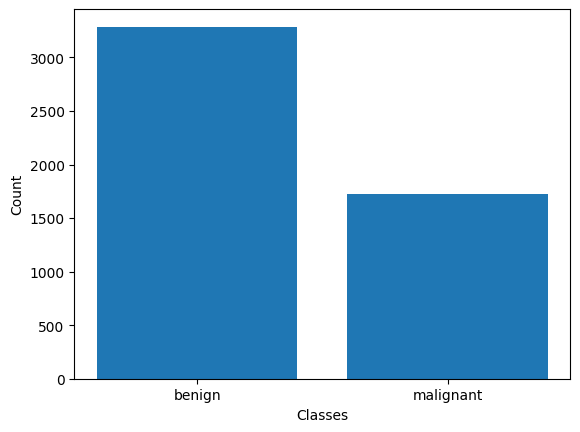

In [43]:
categories= ["benign", "malignant"]
csv_file = pd.read_csv("/content/drive/MyDrive/Outputs/isic_cnn_ISIC_none.csv")
labels = csv_file["label"].to_numpy()
unique, counts = np.unique(labels, return_counts=True)

plt.bar(categories, counts)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

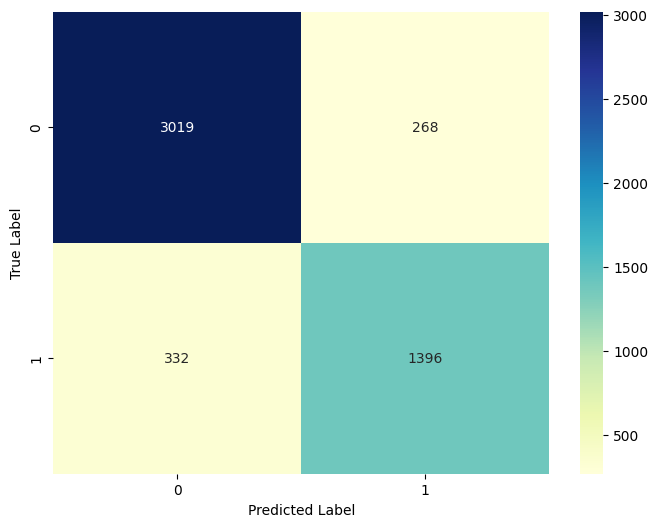

In [44]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
threshold = 0.5

csv_file = pd.read_csv("/content/drive/MyDrive/Outputs/isic_cnn_ISIC_none.csv")

predictions_none = csv_file["prediction"].to_numpy()
labels = csv_file["label"].to_numpy()


# Convert probabilities to predicted labels
predictions = (predictions_none > threshold).astype(int)

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

In [45]:
dict_list = []
for file, path in filenames.items():
    dict_list.append(evaluate_cost(path))

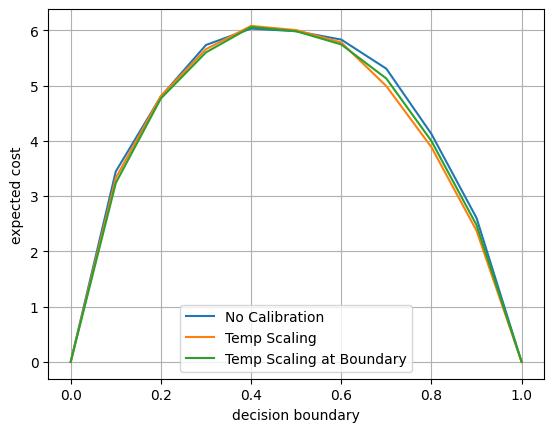

In [46]:
for cost_dict, label in zip(dict_list, ["No Calibration", "Temp Scaling", "Temp Scaling at Boundary"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    plt.plot(x_values, y_values, label=label)
plt.xlabel("decision boundary")
plt.ylabel("expected cost")
plt.legend()
plt.grid(True)
plt.show()


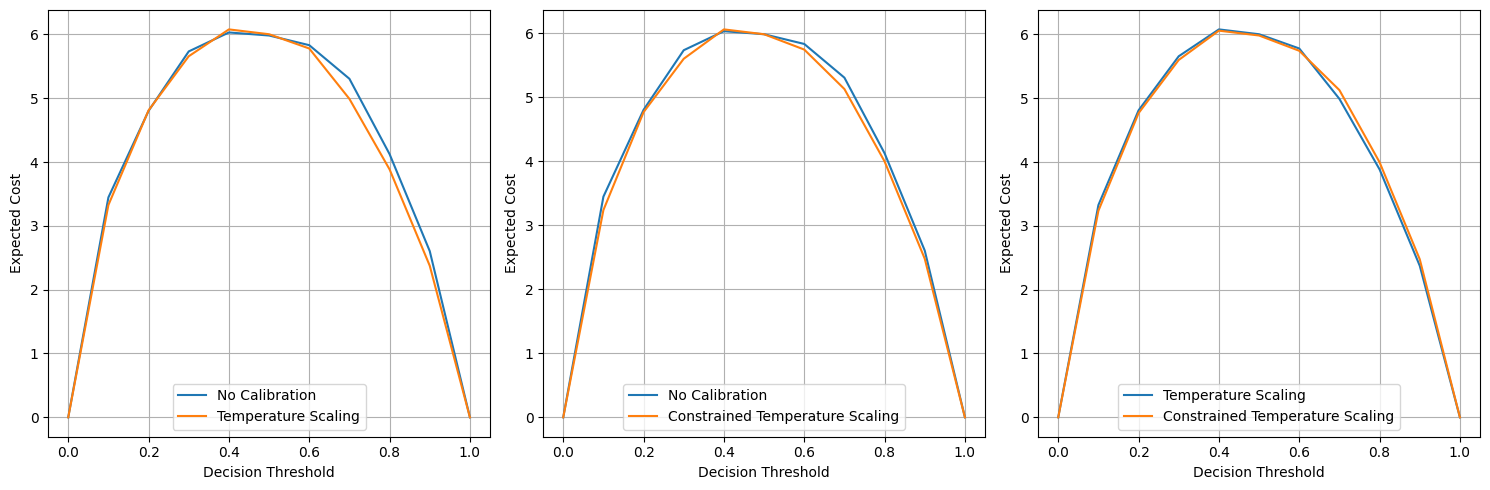

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for cost_dict, label in zip([dict_list[0],dict_list[1]], ["No Calibration", "Temperature Scaling"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    axes[0].plot(x_values, y_values, label=label)
axes[0].grid(True)
axes[0].set_xlabel("Decision Threshold")
axes[0].set_ylabel("Expected Cost")
axes[0].legend()

for cost_dict, label in zip([dict_list[0],dict_list[2]], ["No Calibration", "Constrained Temperature Scaling"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    axes[1].plot(x_values, y_values, label=label)
axes[1].grid(True)
axes[1].set_xlabel("Decision Threshold")
axes[1].set_ylabel("Expected Cost")
axes[1].legend()

for cost_dict, label in zip([dict_list[1],dict_list[2]], ["Temperature Scaling", "Constrained Temperature Scaling"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    axes[2].plot(x_values, y_values, label=label)
axes[2].grid(True)
axes[2].set_xlabel("Decision Threshold")
axes[2].set_ylabel("Expected Cost")
axes[2].legend()

plt.tight_layout()
plt.show()

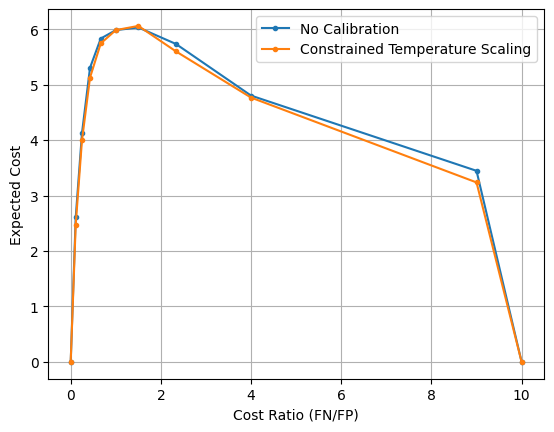

Sum E(cost)
no calibration: 43.8544366899302
constrained scaling: 42.983050847457626


In [48]:
dict_list_per_ratio = []
for file, path in filenames.items():
    dict_list_per_ratio.append(evaluate_cost_per_ratio(path))
for cost_dict, label in zip([dict_list_per_ratio[0],dict_list_per_ratio[2]], ["No Calibration", "Constrained Temperature Scaling"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    plt.plot(x_values, y_values, marker='.', label=label)
plt.xlabel("Cost Ratio (FN/FP)")
plt.ylabel("Expected Cost")
#plt.title("Cost vs Cost ratios")
plt.legend()
plt.grid(True)
plt.show()

print("Sum E(cost)" + "\n" + "no calibration: " + str(sum(dict_list[0].values())) + "\n" + "constrained scaling: " +  str(sum(dict_list[2].values())))

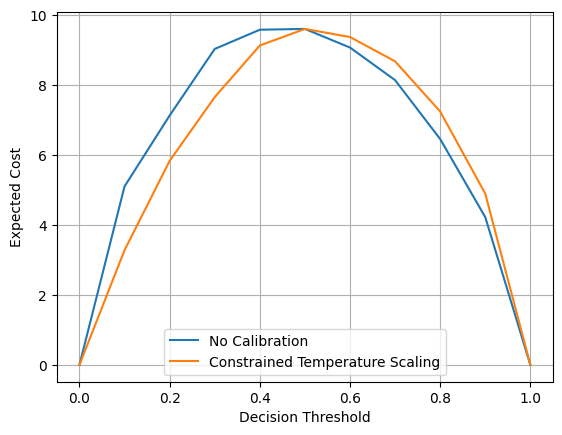

In [49]:
dict_list_true_malignant = []
for file, path in filenames.items():
    dict_list_true_malignant.append(evaluate_true_malignant_cost(path))

for cost_dict, label in zip([dict_list_true_malignant[0], dict_list_true_malignant[2]], ["No Calibration", "Constrained Temperature Scaling"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    plt.plot(x_values, y_values, label=label)
plt.xlabel("Decision Threshold")
plt.ylabel("Expected Cost")
#plt.title("cost vs cost ratios (true malignant)")
plt.legend()
plt.grid(True)
plt.show()

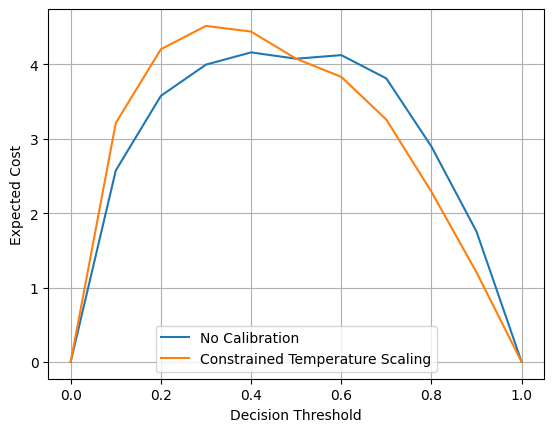

In [50]:
dict_list_true_benign = []
for file, path in filenames.items():
    dict_list_true_benign.append(evaluate_true_benign_cost(path))

for cost_dict, label in zip([dict_list_true_benign[0], dict_list_true_benign[2]], ["No Calibration", "Constrained Temperature Scaling"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    plt.plot(x_values, y_values, label=label)
plt.xlabel("Decision Threshold")
plt.ylabel("Expected Cost")
#plt.title("cost vs cost ratios (true malignant)")
plt.legend()
plt.grid(True)
plt.show()


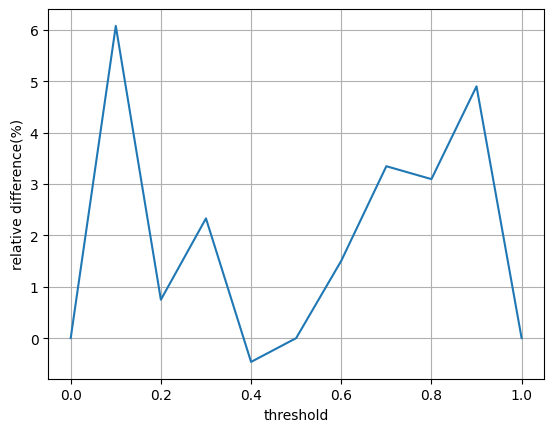

,Decision Threshold,Reduction,Relative Reduction (%)
10,0.0,0.000,0.000
9,0.1,0.209,6.076
8,0.2,0.036,0.748
7,0.3,0.134,2.330
6,0.4,-0.028,-0.463
5,0.5,0.000,0.000
4,0.6,0.088,1.505
3,0.7,0.177,3.346
2,0.8,0.128,3.095
1,0.9,0.128,4.900


In [51]:
cost_dict_none = dict_list[0]
cost_dict_boundary = dict_list[2]
percent_decrease = []
diff = []
# we expect the cost dictionary to be of the same length and of the same order.
for val_none, val_boundary in zip(cost_dict_none.values(), cost_dict_boundary.values()):
  if val_none ==0 and val_boundary == 0:
    percent_decrease.append(0)
    diff.append(0)
  elif val_none == 0 and val_boundary != 0:
    percent_decrease.append(100) #magic, if we see 100, thats a problem
  else:
    diff.append(val_none - val_boundary)
    percent_decrease.append((((val_none - val_boundary)/ val_none))*100)


plt.plot(cost_dict.keys(), percent_decrease)
plt.xlabel("threshold")
plt.ylabel("relative difference(%)")



plt.grid(True)
plt.show()
l1= list(cost_dict_none.keys())

data = {
    'Decision Threshold': l1,
    'Reduction': diff,
    'Relative Reduction (%)': percent_decrease
}
diff_frame = pd.DataFrame(data)
diff_frame[::-1].round(3)


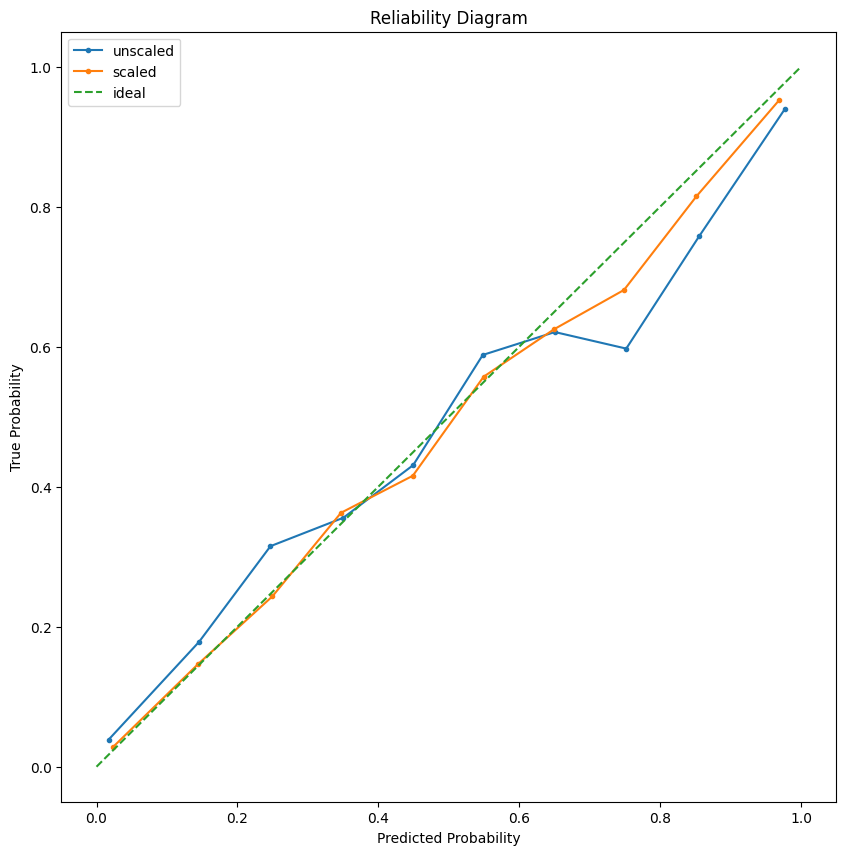

In [52]:
from sklearn.calibration import calibration_curve

csv_file_1 = pd.read_csv("/content/drive/MyDrive/Outputs/isic_cnn_ISIC_none.csv")
labels_1 = csv_file_1["label"].to_numpy()
predictions_1 = csv_file_1["prediction"].to_numpy()

# calibration curve
prob_true, prob_pred = calibration_curve(labels_1, predictions_1, n_bins=10)

# reliability diagram
plt.figure(figsize=(10, 10))
plt.plot(prob_pred, prob_true, marker='.', label="unscaled")
csv_file_2 = pd.read_csv("/content/drive/MyDrive/Outputs/isic_cnn_ISIC_temperature_True.csv")
labels_2 = csv_file_2["label"].to_numpy()
predictions_2 = csv_file_2["prediction"].to_numpy()

prob_true_2, prob_pred_2 = calibration_curve(labels_2, predictions_2, n_bins=10)
plt.plot(prob_pred_2, prob_true_2, marker='.', label="scaled")
plt.plot([0, 1], [0, 1], linestyle='--', label="ideal")
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Reliability Diagram')
plt.legend()
plt.show()




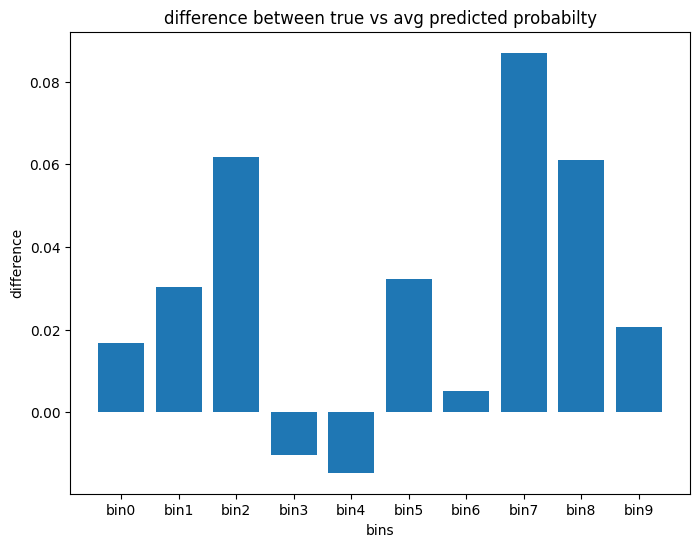

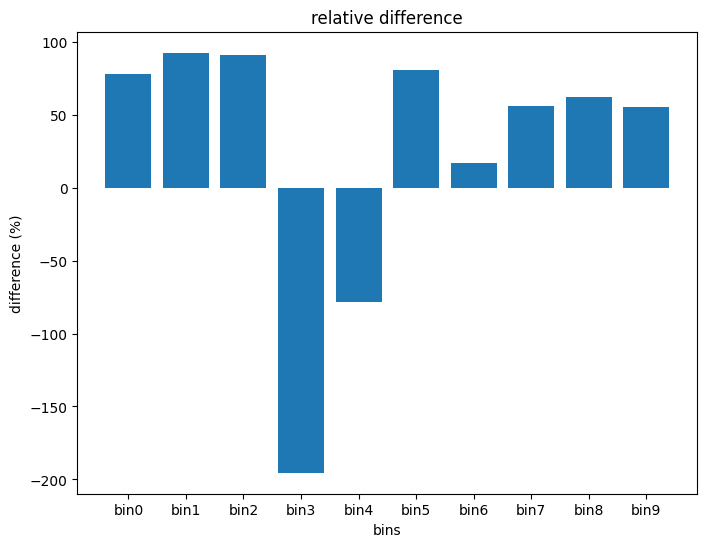

,bins,difference,relative diff
0,bin0,0.016727,77.893029
1,bin1,0.030378,92.592350
2,bin2,0.061864,90.786626
3,bin3,-0.010407,-195.426095
4,bin4,-0.014627,-78.447612
5,bin5,0.032299,80.779280
6,bin6,0.005080,17.167938
7,bin7,0.086986,56.269773
8,bin8,0.060935,62.433290
9,bin9,0.020722,55.411224


In [53]:
from sklearn.calibration import calibration_curve

csv_file_2 = pd.read_csv("/content/drive/MyDrive/Outputs/isic_cnn_ISIC_temperature_True.csv")
labels_2 = csv_file_2["label"].to_numpy()
predictions_2 = csv_file_2["prediction"].to_numpy()

csv_file_1 = pd.read_csv("/content/drive/MyDrive/Outputs/isic_cnn_ISIC_none.csv")
labels_1 = csv_file_1["label"].to_numpy()
predictions_1 = csv_file_1["prediction"].to_numpy()

prob_true_1, prob_pred_1 = calibration_curve(labels_1, predictions_1, n_bins=10)
prob_true_2, prob_pred_2 = calibration_curve(labels_2, predictions_2, n_bins=10)

diff = []
relative_diff = []
bins = []
for index in range(10):
  diff_1 = (abs(prob_pred_1[index] - prob_true_1[index]))
  diff_2 = (abs(prob_pred_2[index] - prob_true_2[index]))
  diff.append(diff_1 - diff_2)
  relative_diff.append(((diff_1 - diff_2)/diff_1)*100 )
  bins.append(f'bin{index}')

data = {
    'bins': bins,
    'difference': diff,
    'relative diff': relative_diff
}

diff_frame = pd.DataFrame(data)
plt.figure(figsize=(8, 6))
plt.bar(bins, diff)
plt.xlabel('bins')
plt.ylabel('difference')
plt.title('difference between true vs avg predicted probabilty')
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(bins, relative_diff)
plt.xlabel('bins')
plt.ylabel('difference (%)')
plt.title('relative difference')
plt.show()

diff_frame

In [54]:
filenames = {"medmnist CNN No Calibration":                         "/content/drive/MyDrive/medmnist_predictions_none.csv",
                   "medmnist CNN Temperature Scaling":                    "/content/drive/MyDrive/medmnist_predictions_temp.csv",
                   "medmnist CNN Temperature Scaling at Boundry":         "/content/drive/MyDrive/medmnist_predictions_mod_temp.csv"
                   }

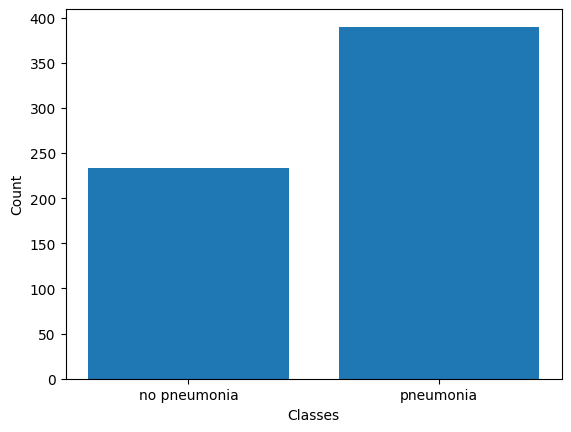

In [55]:
categories= ["no pneumonia", "pneumonia"]
csv_file = pd.read_csv("/content/drive/MyDrive/medmnist_predictions_none.csv")
labels = csv_file["label"].to_numpy()
unique, counts = np.unique(labels, return_counts=True)
plt.bar(categories, counts)

plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

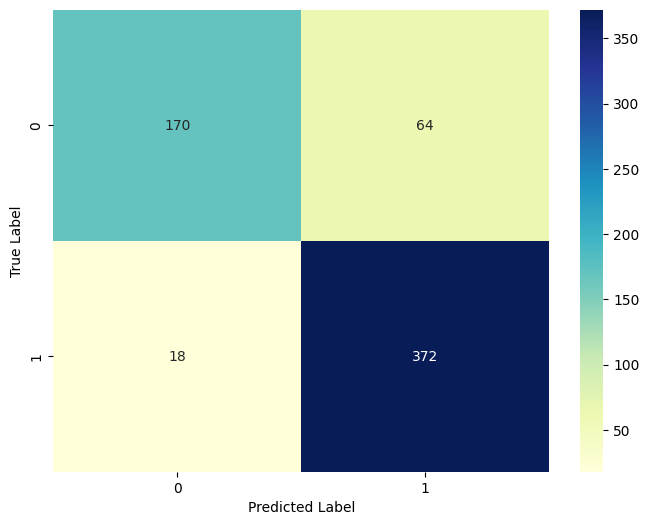

In [56]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
threshold = 0.5

csv_file = pd.read_csv("/content/drive/MyDrive/medmnist_predictions_none.csv")

predictions_none = csv_file["prediction"].to_numpy()
labels = csv_file["label"].to_numpy()


# Convert probabilities to predicted labels
predictions = (predictions_none > threshold).astype(int)

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

In [57]:
dict_list = []
for file, path in filenames.items():
    dict_list.append(evaluate_cost(path))

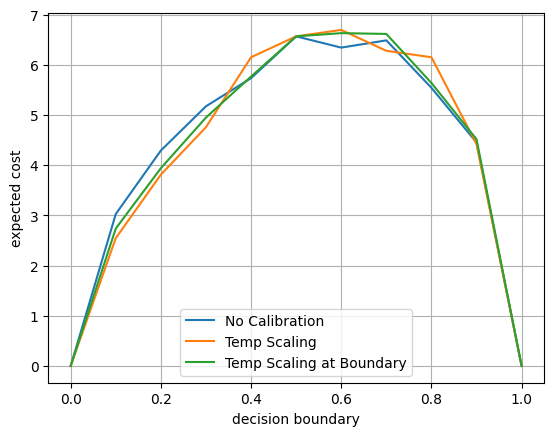

In [58]:
for cost_dict, label in zip(dict_list, ["No Calibration", "Temp Scaling", "Temp Scaling at Boundary"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    plt.plot(x_values, y_values, label=label)
plt.xlabel("decision boundary")
plt.ylabel("expected cost")
plt.legend()
plt.grid(True)
plt.show()

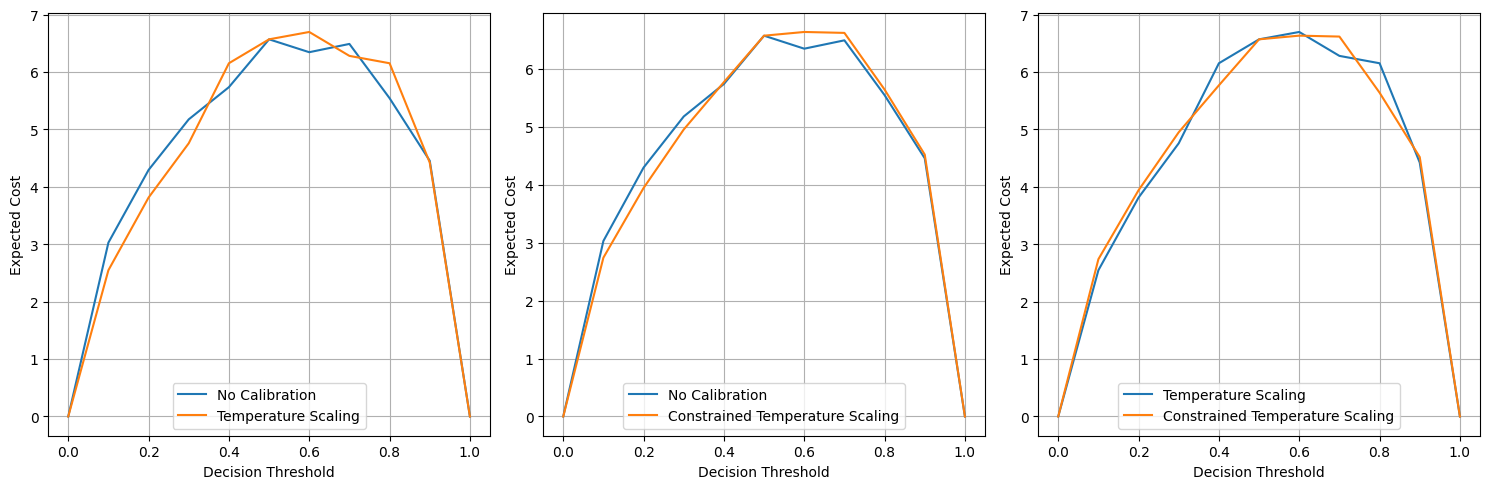

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for cost_dict, label in zip([dict_list[0],dict_list[1]], ["No Calibration", "Temperature Scaling"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    axes[0].plot(x_values, y_values, label=label)
axes[0].grid(True)
axes[0].set_xlabel("Decision Threshold")
axes[0].set_ylabel("Expected Cost")
axes[0].legend()

for cost_dict, label in zip([dict_list[0],dict_list[2]], ["No Calibration", "Constrained Temperature Scaling"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    axes[1].plot(x_values, y_values, label=label)
axes[1].grid(True)
axes[1].set_xlabel("Decision Threshold")
axes[1].set_ylabel("Expected Cost")
axes[1].legend()

for cost_dict, label in zip([dict_list[1],dict_list[2]], ["Temperature Scaling", "Constrained Temperature Scaling"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    axes[2].plot(x_values, y_values, label=label)
axes[2].grid(True)
axes[2].set_xlabel("Decision Threshold")
axes[2].set_ylabel("Expected Cost")
axes[2].legend()

plt.tight_layout()
plt.show()

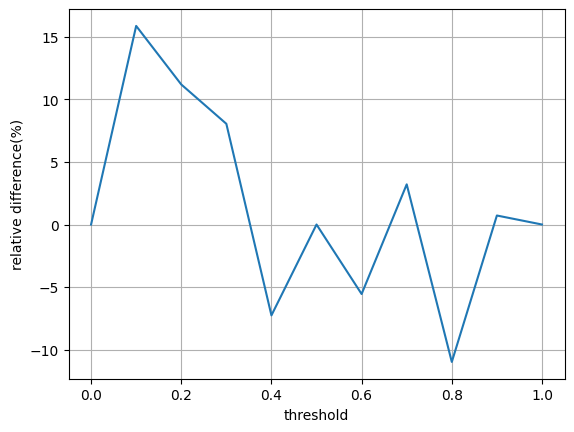

,Decision Threshold,Reduction,Relative Reduction (%)
10,0.0,0.000,0.000
9,0.1,0.481,15.873
8,0.2,0.481,11.194
7,0.3,0.417,8.050
6,0.4,-0.417,-7.263
5,0.5,0.000,0.000
4,0.6,-0.353,-5.556
3,0.7,0.208,3.210
2,0.8,-0.609,-10.983
1,0.9,0.032,0.719


In [60]:
cost_dict_none = dict_list[0]
cost_dict_boundary = dict_list[1]
percent_decrease = []
diff = []
# we expect the cost dictionary to be of the same length and of the same order.
for val_none, val_boundary in zip(cost_dict_none.values(), cost_dict_boundary.values()):
  if val_none ==0 and val_boundary == 0:
    percent_decrease.append(0)
    diff.append(0)
  elif val_none == 0 and val_boundary != 0:
    percent_decrease.append(100) #magic, if we see 100, thats a problem
  else:
    diff.append(val_none - val_boundary)
    percent_decrease.append((((val_none - val_boundary)/ val_none))*100)


plt.plot(cost_dict.keys(), percent_decrease)
plt.xlabel("threshold")
plt.ylabel("relative difference(%)")



plt.grid(True)
plt.show()
l1= list(cost_dict_none.keys())

data = {
    'Decision Threshold': l1,
    'Reduction': diff,
    'Relative Reduction (%)': percent_decrease
}
diff_frame = pd.DataFrame(data)
diff_frame[::-1].round(3)
